# makemore, but made with an MLP (Multi-Layer Perceptron)


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    torch.set_default_device(mps_device)

In [2]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]  # show first 8 words

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)  # how many words do we have?

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))  # unique characters in the words
stoi = {s: i + 1 for i, s in enumerate(chars)}  # string to integer mapping
stoi["."] = 0  # add a special end-of-word character
itos = {i: s for s, i in stoi.items()}  # integer to string mapping
vocab_size = len(itos)  # size of the vocabulary
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Buiding the dataset


In [5]:
# Building the dataset
block_size = (
    5  # Context length: how many characters do we take to predict the next character?
)

def build_dataset(words):
    # The block size determines how many previous characters we consider to predict the next character.
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)  # for reproducibility
random.shuffle(words)  # shuffle the words to ensure randomness
n1 = int(0.8 * len(words))  # 80% for training
n2 = int(0.9 * len(words))  # 10% for validation

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [6]:
# MLP Improvements
n_embd = 16 # The dimensionality of the character embedding vectors
n_hidden = 256 # The number of neurons in the hidden layer of the MLP

g = torch.Generator(device=mps_device).manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)  # character embeddings
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)  # first layer weights
b1 = torch.randn((n_hidden,), generator=g)  # first layer bias
W2 = torch.randn((n_hidden, vocab_size), generator=g)  # second layer weights
b2 = torch.randn((vocab_size,), generator=g)  # second layer bias

parameters = [C, W1, b1, W2, b2]
print(sum(p.numel() for p in parameters)) # total number of parameters

for p in parameters:
    p.requires_grad = True  # enable gradients for all parameters

28107


2.025907516479492


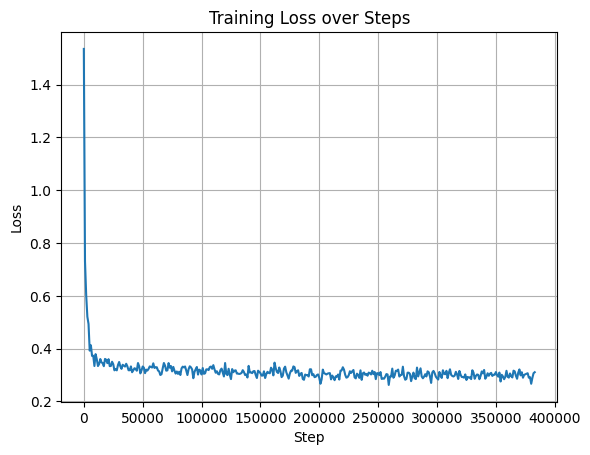

In [7]:
batch_size = 512  # size of the mini-batch
max_steps = 384000
lossi = []
stepi = []

for i in range(max_steps):
    # Construct Mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)  # random indices for the mini-batch
    Xb, Yb = X_train[ix], Y_train[ix]

    emb = C[Xb]  # get embeddings for the input characters
    embcat = emb.view(emb.shape[0], -1) # Concatenate embeddings
    hpreact = embcat @ W1 + b1 # Hidden layer pre-activation
    h = torch.tanh(hpreact)  # apply activation
    logits = h @ W2 + b2  # compute logits for the output layer
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in parameters:
        p.grad = None  # zero out gradients

    loss.backward()  # compute gradients
    # Update parameters
    # lr = lrs[i]
    lr = 0.1
    if i > max_steps / 2:
        lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad  # update parameters using gradient descent

    # Track stats
    # lri.append(lre[i].cpu())
    if i % 1000 == 0:
        lossi.append(loss.log10().item())
        stepi.append(i)

print(loss.item())  # print the loss value
# plt.plot(lri, lossi)
plt.plot(stepi, lossi)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.grid()
plt.show()

## Split Loss Calculation

In [12]:
@torch.no_grad()  # disable gradient tracking for evaluation
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]
    emb = C[x]  # get embeddings for the input characters
    embcat = emb.view(emb.shape[0], -1)  # concatenate embeddings
    h = torch.tanh(embcat @ W1 + b1)  # apply linear transformation and activation
    logits = h @ W2 + b2  # compute logits for the output layer
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 1.990581750869751
val 2.0831894874572754
test 2.077301502227783


### Training the model on the entirety of the data for all passes will lead to a very large training time, so we will use batches of data for training

It is generally better to train smaller batches of data though the gradient is not as accurate, but its better to take many small steps than a few large steps.
### Training split, dev/validation split, test split
### 80%. 10%, 10% split


Since the training and dev set lossi are very similar, we can assume that the model is not overfitting and is generalizing well to the dev set.
This model is not powerful enough to learn the patterns in the data/purely memorizing the data, so we can safely increase the size of the model by increasing the number of hidden units in the first layer, or by adding more layers to the model to improve the performance of the model.

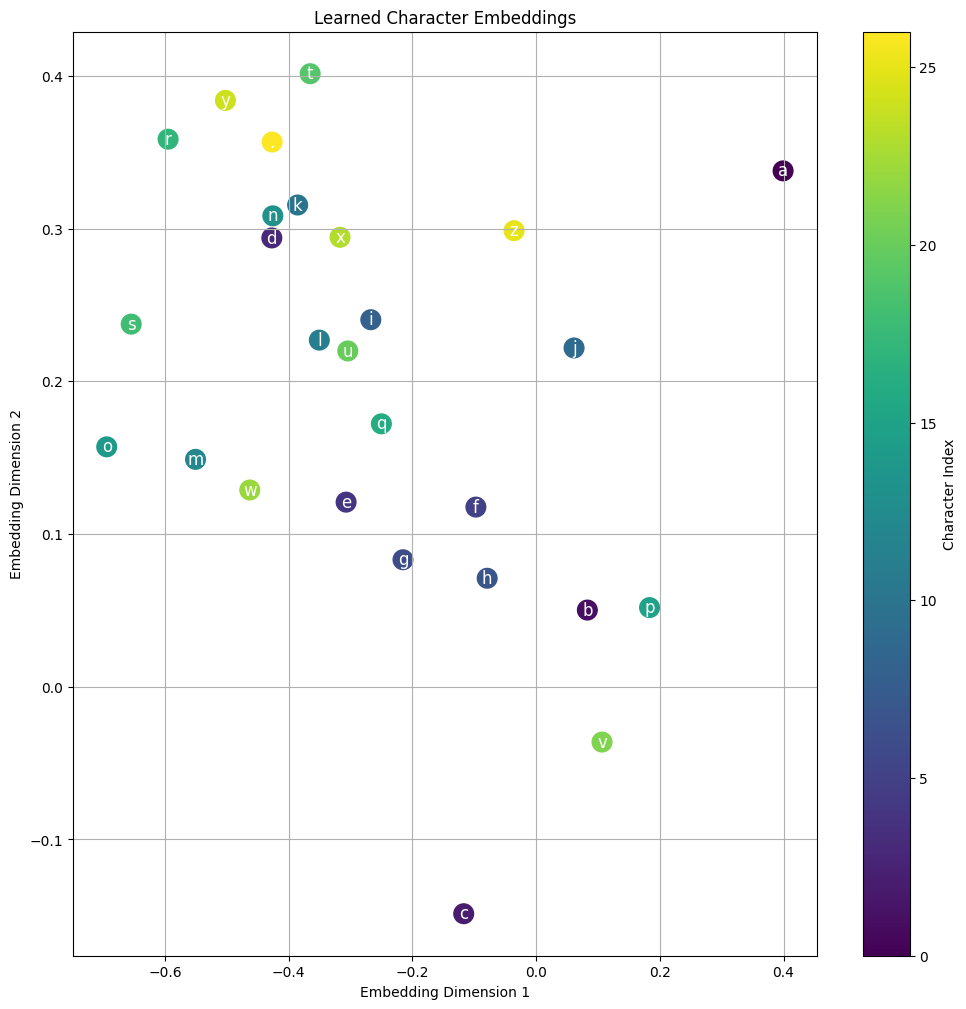

In [13]:
# # Visualise the learned embeddings
plt.figure(figsize=(12, 12))
plt.scatter(
    C[:, 0].detach().cpu().numpy(),
    C[:, 1].detach().cpu().numpy(),
    s=200,
    c=range(len(C)),
    cmap='viridis',
)
for i, ch in enumerate(itos.values()):
    plt.text(
        C[i, 0].item(),
        C[i, 1].item(),
        ch,
        fontsize=12,
        ha='center',
        va='center',
        color='white',
    )
plt.title("Learned Character Embeddings")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.colorbar(label='Character Index')
plt.grid()
plt.show()


In [14]:
# Sample from the model
g = torch.Generator(device=mps_device).manual_seed(2147483647 + 10)  # set random seed

for _ in range(25):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context, device=mps_device)]  # get embeddings for the context
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)  # apply linear transformation and activation
        logits = h @ W2 + b2  # compute logits for the output layer
        prob = F.softmax(logits, dim=-1)

        ix = torch.multinomial(prob, num_samples=1, generator=g).item()  # sample from the distribution
        context = context[1:] + [ix]  # slide the window, add new character
        out.append(ix)
        if ix == 0:  # end of word character
            break
        
    print(''.join(itos[i] for i in out))

giartarious.
dezeriel.
breyq.
rwcenzoll.
carsid.
jerren.
einel.
cales.
lilyah.
ryd.
matvien.
scoria.
kasialeen.
asate.
estyn.
elizx.
analoi.
shain.
kiliea.
keana.
miklynn.
mikheanna.
damylonne.
shuiab.
salina.
